# Exploratory Data Analysis

-----------

In [ ]:
import pandas as pd
import numpy as np
engine='python'

# Visualization Libraries
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.markers import MarkerStyle
import seaborn as sns

# Text analysis helper libraries
from gensim.summarization import summarize
from gensim.summarization import keywords
from gensim.models import KeyedVectors

# Text analysis helper libraries for word frequency etc..
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
import nltk

# Word cloud visualization libraries
from scipy.misc import imresize
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from collections import Counter

%matplotlib inline

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dibakarsigdel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dibakarsigdel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

-------

### Getting Data

In [3]:
train = pd.read_csv('data.csv')

--------

We can separate text and label

In [4]:
text = train['Text']
label = train['Label']

Unique labels are

In [5]:
label.unique()

array(['MISC', 'AIMX', 'OWNX', 'CONT', 'BASE'], dtype=object)

Lets count class frequency and plot them

In [6]:
train.groupby(['Label'])['Text'].count()

Label
AIMX     194
BASE      61
CONT     170
MISC    1825
OWNX     867
Name: Text, dtype: int64

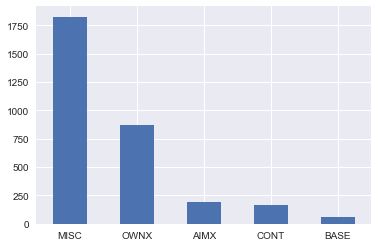

In [7]:
train['Label'].value_counts().plot(kind="bar", rot=0)

Classes are little bit imbalanced.

Lets look at the text properties  regarding each classes

In [8]:
# Set of unique label
lbl_set = list(set(label))

In [9]:
# Ahelper function to count words per line within the preferred class
def line_length_counter(all_label,all_text,class_name):
    
    class_txt = []
    
    # Seperate all lines for a class
    for lbl , txt in zip(all_label,all_text):
        if lbl == class_name:
            class_txt.append(txt)
            
     # Count words per line of that class       
    line_word_count = []
    for k in range(len(class_txt)):
        line_words = class_txt[k].lower().split()
        line_word_count.append(len(line_words))
        
    return np.sort(line_word_count)

#### Plot of text length in seperate classes

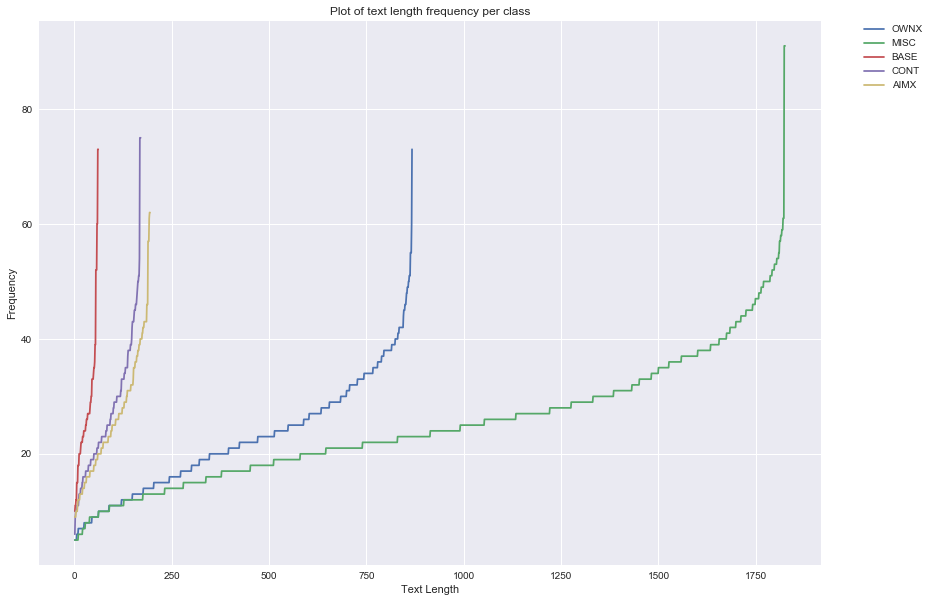

In [10]:
plt.figure(figsize = [14,10])
for lbl in lbl_set:
    count = line_length_counter(label,text,lbl)
    plt.plot(np.arange(1, len(count)+1,1),count, label = lbl)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Plot of text length frequency per class")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

------------

### Histogram of most common word frequency and  bigram using nltk

In [223]:
freq = nltk.FreqDist(words)
freq_df = pd.DataFrame(freq, index = ['freq']).transpose()
word_list = list(freq_df.index)

In [ ]:
import seaborn as sns
plt.figure(figsize = (18,100))
sns.barplot(x ="freq", y = word_list, data = freq_df[0:100].sort());
plt.title('Test Accuracy')

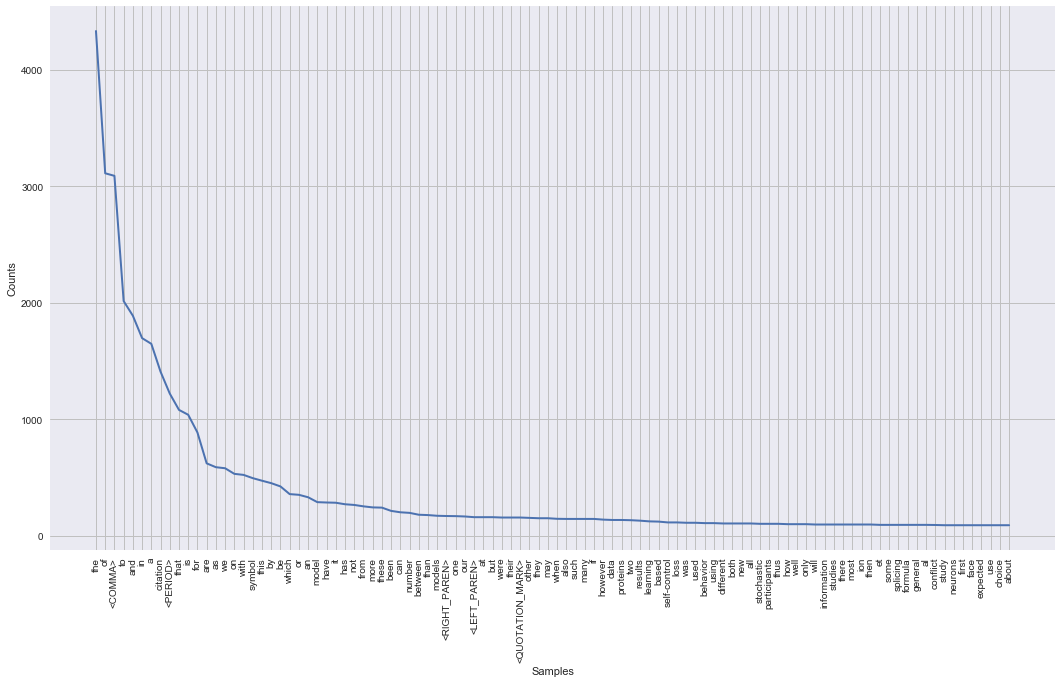

In [21]:
plt.figure(figsize = (18,10))
freq.most_common(20)
freq.plot(100)

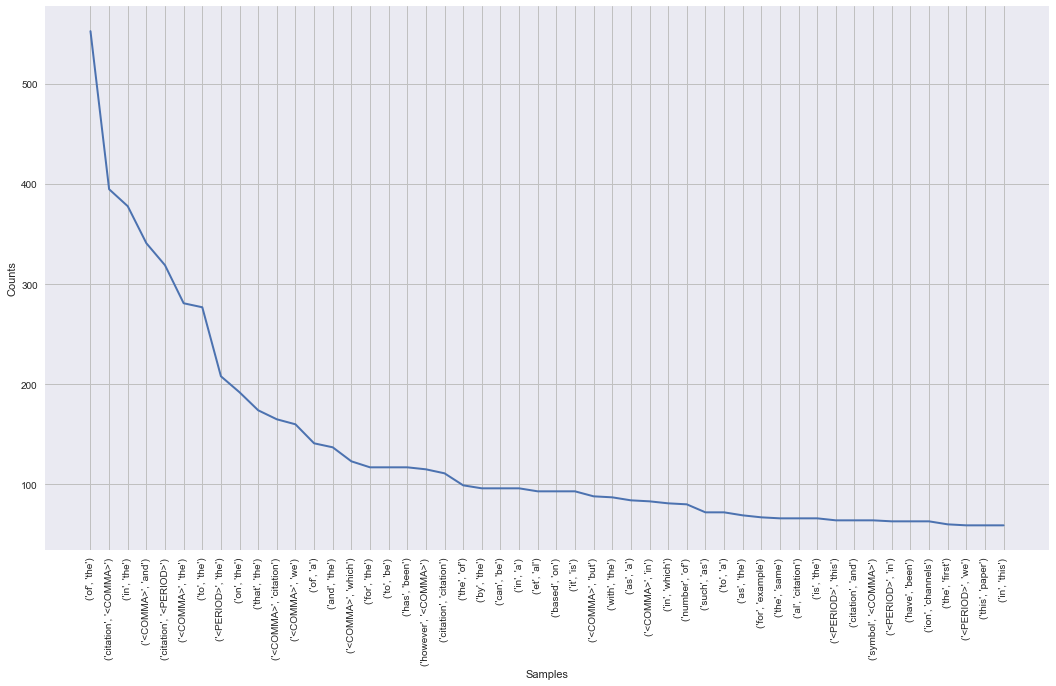

In [25]:
bigrams = nltk.bigrams(words)
# Calculate Frequency Distribution for Bigrams
freq_bi = nltk.FreqDist(bigrams)

plt.figure(figsize = (18,10))
# Print and plot most common bigrams
freq_bi.most_common(20)
freq_bi.plot(50)

---------

### Plotting Class Frequent words

In [12]:
custom_words = ["fig", "figure", "et", "al", "al.", "also",
                "data", "analyze", "study", "table", "using",
                "method", "result", "conclusion", "author", 
                "find", "found", "show", '"', "’", "“", "”","_","-",
                "although", "difficult","based","many","two","one"]

In [13]:
stop_words = set(stopwords.words('english') + list(punctuation) + custom_words)
wordnet_lemmatizer = WordNetLemmatizer()

In [14]:
class_corpus = train.groupby('Label').apply(lambda x: x['Text'].str.cat())

class_corpus = class_corpus.apply(lambda x: 
               Counter([wordnet_lemmatizer.lemmatize(w) for w in word_tokenize(x) 
               if w.lower() not in stop_words and not w.isdigit()]))

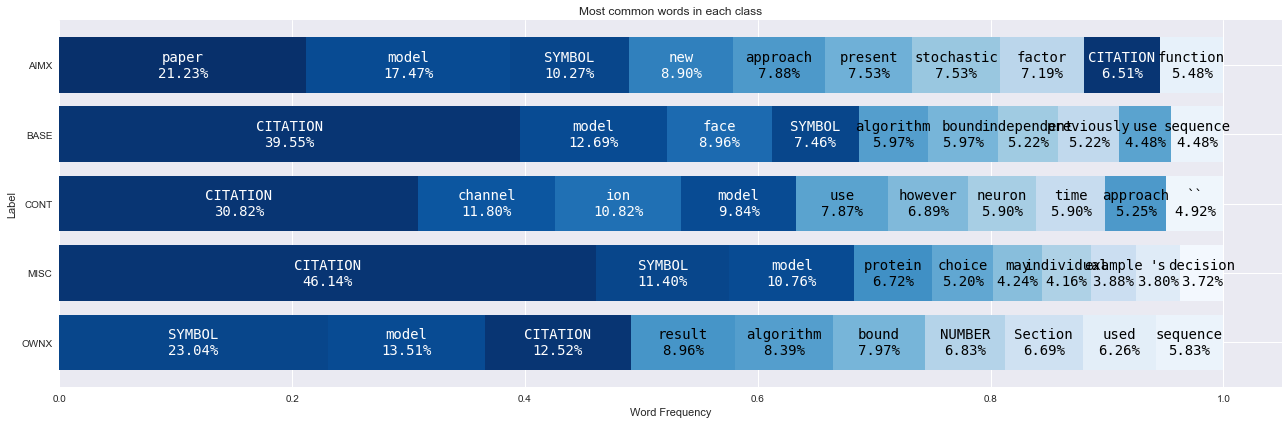

In [23]:
class_freq = class_corpus.apply(lambda x: x.most_common(10))
class_freq = pd.DataFrame.from_records(class_freq.values.tolist()).set_index(class_freq.index)

def normalize_row(x):
    label, repetition = zip(*x)
    t = sum(repetition)
    r = [n/t for n in repetition]
    return list(zip(label,r))

class_freq = class_freq.apply(lambda x: normalize_row(x), axis=1)




# set unique colors for each word so it's easier to read
all_labels = [x for x in class_freq.sum().sum() if isinstance(x,str)]
unique_labels = set(all_labels)
cm = plt.get_cmap('Blues_r', len(all_labels))
colors = {k:cm(all_labels.index(k)/len(all_labels)) for k in all_labels}

fig, ax = plt.subplots()

offset = np.zeros(5)
for r in class_freq.iteritems():
    label, repetition = zip(*r[1])
    ax.barh(range(len(class_freq)), repetition, left=offset, color=[colors[l] for l in label])
    offset += repetition
    
ax.set_yticks(np.arange(len(class_freq)))
ax.set_yticklabels(class_freq.index)
ax.invert_yaxis()





# annotate words
offset_x = np.zeros(5) 
for idx, a in enumerate(ax.patches):
    fc = 'k' if sum(a.get_fc()) > 2.5 else 'w'
    ax.text(offset_x[idx%5] + a.get_width()/2, a.get_y() + a.get_height()/2, 
            '{}\n{:.2%}'.format(all_labels[idx], a.get_width()), 
            ha='center', va='center', color=fc, fontsize=14, family='monospace')
    offset_x[idx%5] += a.get_width()
    
ax.set_title('Most common words in each class')
ax.set_xlabel('Word Frequency')
ax.set_ylabel('Label')

plt.tight_layout()
plt.show()
plt.rcParams["figure.figsize"] = (18, 6)

#### Plotting Word frequencies from all text

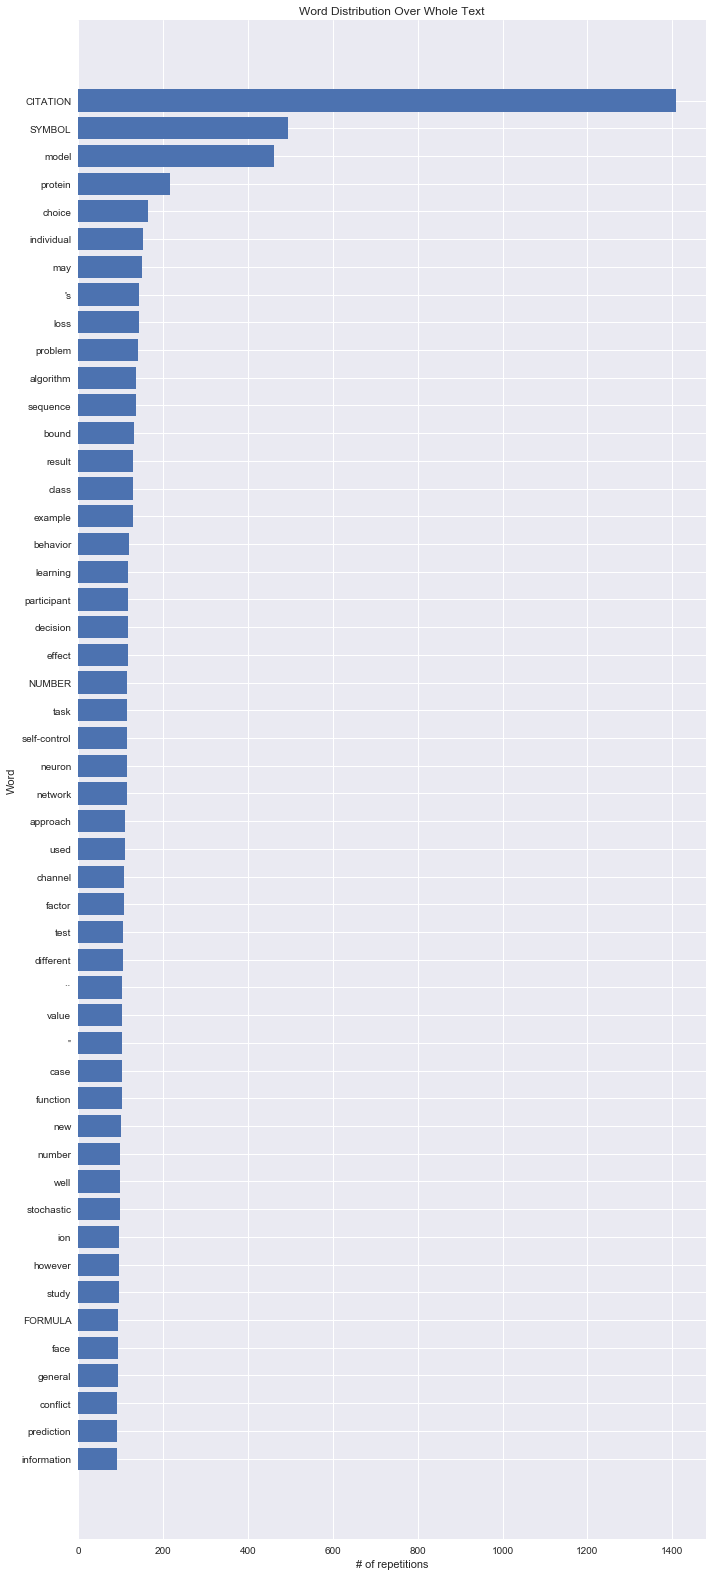

In [24]:
plt.rcParams["figure.figsize"] = (10, 22)
whole_text_freq = class_corpus.sum()

fig, ax = plt.subplots()

label, repetition = zip(*whole_text_freq.most_common(50))

ax.barh(range(len(label)), repetition, align='center')
ax.set_yticks(np.arange(len(label)))
ax.set_yticklabels(label)
ax.invert_yaxis()

ax.set_title('Word Distribution Over Whole Text')
ax.set_xlabel('# of repetitions')
ax.set_ylabel('Word')

plt.tight_layout()
plt.show()


#### Plotting Word Cloud

In [15]:

# Collecting all text
all_txt = ''
for k in range(len(text)):
           txt = text.iloc[k]
           all_txt = all_txt+txt


In [16]:
# Helper function to preprocess text

def preprocess(text):

    # Replace punctuation with tokens so we can use them in our model
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    # text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <COLON> ')
    words = text.split()
    
    # Remove all words with  5 or fewer occurences
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > 5]

    return trimmed_words

In [17]:
words = preprocess(all_txt)
print(words[:30])

['the', 'minimum', 'description', 'length', 'principle', 'for', 'sequence', 'in', 'a', 'proper', 'learning', 'setup', 'is', 'studied', 'if', 'the', 'underlying', 'model', 'class', 'is', 'discrete', '<COMMA>', 'then', 'the', 'total', 'expected', 'square', 'loss', 'is', 'a']


#### Word Cloud

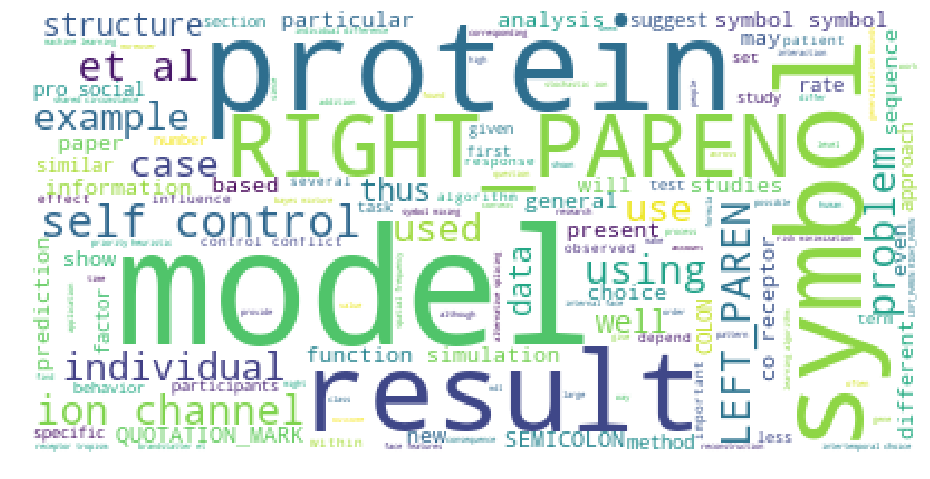

In [14]:
from wordcloud import WordCloud, STOPWORDS

# Combine all reviews for the desired sentiment
combined_text = " ".join([wd for wd in words])

# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=200,
        stopwords = STOPWORDS.update(['COMMA','one','other','PERIOD',
                                      'citation','many','two','also','however']))

# Generate and plot wordcloud
plt.figure(figsize =[16,16])
plt.imshow(wc.generate(combined_text))
plt.axis('off')
plt.show()

### Conclusion

Classes in the train data are highly imbalanced. Generating new data through data augmentation or simulation could be helpful.

--------